In [42]:
#import libraries
import xgboost as xgb
import itertools
from prophet import Prophet
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv("D:/Forecasting Models and Time Series for Business in Python/Daily Bike Sharing.csv")
data.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [32]:
#select variables
dataset = data.loc[:, ["dteday","cnt", "holiday", "workingday", "weathersit",
                       "temp", "atemp", "hum", "windspeed"]]
dataset.head()                       

,dteday,cnt,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [33]:
#Date variable
dataset.dteday = pd.to_datetime(dataset.dteday,
                                format = "%Y-%m-%d")
dataset.dteday

0     2011-01-01
1     2011-01-02
2     2011-01-03
3     2011-01-04
4     2011-01-05
         ...    
726   2012-12-27
727   2012-12-28
728   2012-12-29
729   2012-12-30
730   2012-12-31
Name: dteday, Length: 731, dtype: datetime64[ns]

In [34]:
#renaming variable
dataset = dataset.rename(columns = {'cnt' : 'y'})
dataset = dataset.rename(columns = {'dteday' : 'ds'})
dataset.head()

,ds,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
1,2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2,2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
3,2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
4,2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [35]:
holiday_dates = dataset[dataset.holiday == 1].ds
holidays = pd.DataFrame({'holiday' : 'holi',
                         'ds': pd.to_datetime(holiday_dates),
                         'lower_window': -3,
                         'upper_window': 1})
holidays.head()

,holiday,ds,lower_window,upper_window
16,holi,2011-01-17,-3,1
51,holi,2011-02-21,-3,1
104,holi,2011-04-15,-3,1
149,holi,2011-05-30,-3,1
184,holi,2011-07-04,-3,1


In [36]:
#removing holiday column
dataset = dataset.drop(columns = "holiday")
dataset.head(1)

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446


In [37]:
#Training and test set
test_days = 31
training_set = dataset.iloc[:-test_days, :]
test_set = dataset.iloc[-test_days:, :]
test_set.tail()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,2114,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,3095,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,1341,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,1796,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,2729,1,2,0.215833,0.223487,0.577500,0.154846


In [38]:
#Facebook Prophet model
m = Prophet(growth = "linear",
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 20,
            holidays_prior_scale = 20,
            changepoint_prior_scale = 0.01)
m.add_regressor('workingday')
m.add_regressor('weathersit')
m.add_regressor('temp')
m.add_regressor('atemp')
m.add_regressor('hum')
m.add_regressor('windspeed')
m.fit(training_set)

18:12:20 - cmdstanpy - INFO - Chain [1] start processing
18:12:20 - cmdstanpy - INFO - Chain [1] done processing


In [39]:
#Create Future Dataframe
future = m.make_future_dataframe(periods = len(test_set),
                                 freq = "D")
future.tail()

,ds
726,2012-12-27
727,2012-12-28
728,2012-12-29
729,2012-12-30
730,2012-12-31


In [40]:
#merge regressors
future = pd.concat([future, dataset.iloc[:,2:]],
                   axis = 1)
future.tail()

,ds,workingday,weathersit,temp,atemp,hum,windspeed
726,2012-12-27,1,2,0.254167,0.226642,0.652917,0.350133
727,2012-12-28,1,2,0.253333,0.255046,0.590000,0.155471
728,2012-12-29,0,2,0.253333,0.242400,0.752917,0.124383
729,2012-12-30,0,1,0.255833,0.231700,0.483333,0.350754
730,2012-12-31,1,2,0.215833,0.223487,0.577500,0.154846


In [41]:
#forecast
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,atemp,atemp_lower,atemp_upper,extra_regressors_multiplicative,...,workingday,workingday_lower,workingday_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2011-01-01,2429.776904,274.639879,2164.623680,2429.776904,2429.776904,-0.055503,-0.055503,-0.055503,-0.279363,...,0.0000,0.0000,0.0000,-0.261834,-0.261834,-0.261834,0.0,0.0,0.0,1256.244173
1,2011-01-02,2435.398244,52.781019,1982.814006,2435.398244,2435.398244,-0.060175,-0.060175,-0.060175,-0.288137,...,0.0000,0.0000,0.0000,-0.255753,-0.255753,-0.255753,0.0,0.0,0.0,1010.113438
2,2011-01-03,2441.019585,370.166907,2254.347723,2441.019585,2441.019585,-0.137830,-0.137830,-0.137830,-0.188039,...,0.0333,0.0333,0.0333,-0.248428,-0.248428,-0.248428,0.0,0.0,0.0,1312.884965
3,2011-01-04,2446.640925,450.453198,2305.364375,2446.640925,2446.640925,-0.127095,-0.127095,-0.127095,-0.177352,...,0.0333,0.0333,0.0333,-0.239970,-0.239970,-0.239970,0.0,0.0,0.0,1421.956309
4,2011-01-05,2452.262265,639.018538,2532.923198,2452.262265,2452.262265,-0.118992,-0.118992,-0.118992,-0.111656,...,0.0333,0.0333,0.0333,-0.230511,-0.230511,-0.230511,0.0,0.0,0.0,1599.486159


In [43]:
#XGBoost

prophet_variables = forecast.loc[:, ["trend", "holi", "weekly", "yearly"]]
df_xgb = pd.concat([dataset, prophet_variables], axis = 1)
df_xgb.head()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
0,2011-01-01,985,0,2,0.344167,0.363625,0.805833,0.160446,2429.776904,0.0,0.058217,-0.261834
1,2011-01-02,801,0,2,0.363478,0.353739,0.696087,0.248539,2435.398244,0.0,-0.041346,-0.255753
2,2011-01-03,1349,1,1,0.196364,0.189405,0.437273,0.248309,2441.019585,0.0,-0.025690,-0.248428
3,2011-01-04,1562,1,1,0.200000,0.212122,0.590435,0.160296,2446.640925,0.0,-0.001490,-0.239970
4,2011-01-05,1600,1,1,0.226957,0.229270,0.436957,0.186900,2452.262265,0.0,-0.005584,-0.230511


In [44]:
#Training and test set
test_days = 31
training_set = df_xgb.iloc[:-test_days, :]
test_set = df_xgb.iloc[-test_days:, :]
test_set.tail()

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
726,2012-12-27,2114,1,2,0.254167,0.226642,0.652917,0.350133,6403.273056,0.0,0.003053,-0.272033
727,2012-12-28,3095,1,2,0.253333,0.255046,0.590000,0.155471,6408.712615,0.0,0.012840,-0.272269
728,2012-12-29,1341,0,2,0.253333,0.242400,0.752917,0.124383,6414.152175,0.0,0.058217,-0.271072
729,2012-12-30,1796,0,1,0.255833,0.231700,0.483333,0.350754,6419.591735,0.0,-0.041346,-0.268434
730,2012-12-31,2729,1,2,0.215833,0.223487,0.577500,0.154846,6425.031294,0.0,-0.025690,-0.264379


In [45]:
#isolate X and Y
y_train = training_set.y
y_test = test_set.y
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]

In [46]:
#create XGBoost Matrices
Train = xgb.DMatrix(data = X_train, label = y_train)
Test = xgb.DMatrix(data = X_test, label = y_test)

In [50]:
#Set the parameters
parameters = {'learning_rate': 0.1,
              'max_depth': 3,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight': 1,
              'gamma': 1,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

In [52]:
#XGBoost Model
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 100,
                  evals = [(Test, "y")])

[0]	y-rmse:3891.58894
[1]	y-rmse:3563.69059
[2]	y-rmse:3274.75734
[3]	y-rmse:2950.62380
[4]	y-rmse:2716.06266
[5]	y-rmse:2522.39072
[6]	y-rmse:2317.96280
[7]	y-rmse:2156.40260
[8]	y-rmse:2024.56200
[9]	y-rmse:1934.05555
[10]	y-rmse:1866.22580
[11]	y-rmse:1791.30150
[12]	y-rmse:1740.37022
[13]	y-rmse:1686.21001
[14]	y-rmse:1645.00477
[15]	y-rmse:1607.49185
[16]	y-rmse:1550.18027
[17]	y-rmse:1505.37005
[18]	y-rmse:1497.57975
[19]	y-rmse:1468.93298
[20]	y-rmse:1447.49851
[21]	y-rmse:1470.55166
[22]	y-rmse:1458.53921
[23]	y-rmse:1450.04251
[24]	y-rmse:1436.79017
[25]	y-rmse:1437.45231
[26]	y-rmse:1434.34955
[27]	y-rmse:1426.79344
[28]	y-rmse:1405.47873
[29]	y-rmse:1382.48373
[30]	y-rmse:1368.36629
[31]	y-rmse:1372.42708
[32]	y-rmse:1364.42167
[33]	y-rmse:1354.23317
[34]	y-rmse:1351.62577
[35]	y-rmse:1345.77694
[36]	y-rmse:1345.84280
[37]	y-rmse:1341.13245
[38]	y-rmse:1338.39152
[39]	y-rmse:1326.23727
[40]	y-rmse:1326.54284
[41]	y-rmse:1325.68060
[42]	y-rmse:1313.05545
[43]	y-rmse:1304.0738

In [53]:
#Forecasting
predictions_xgb = pd.Series(model.predict(Test), name = "XGBoost")
predictions_xgb.index = test_set.ds
predictions_xgb[:2]

ds
2012-12-01    3996.192383
2012-12-02    3068.570312
Name: XGBoost, dtype: float32

In [56]:
#set up index
training_set.index = training_set.ds
test_set.index = test_set.ds

,ds,y,workingday,weathersit,temp,atemp,hum,windspeed,trend,holi,weekly,yearly
ds,,,,,,,,,,,,
2012-12-01,2012-12-01,5191,0,2,0.298333,0.316904,0.806667,0.059704,6261.844503,0.000000,0.058217,-0.138118
2012-12-02,2012-12-02,4649,0,2,0.347500,0.359208,0.823333,0.124379,6267.284063,0.000000,-0.041346,-0.137838
2012-12-03,2012-12-03,6234,1,1,0.452500,0.455796,0.767500,0.082721,6272.723623,0.000000,-0.025690,-0.137884
2012-12-04,2012-12-04,6606,1,1,0.475833,0.469054,0.733750,0.174129,6278.163182,0.000000,-0.001490,-0.138389
2012-12-05,2012-12-05,5729,1,1,0.438333,0.428012,0.485000,0.324021,6283.602742,0.000000,-0.005584,-0.139469
2012-12-06,2012-12-06,5375,1,1,0.255833,0.258204,0.508750,0.174754,6289.042302,0.000000,0.003053,-0.141227
2012-12-07,2012-12-07,5008,1,2,0.320833,0.321958,0.764167,0.130600,6294.481862,0.000000,0.012840,-0.143742
2012-12-08,2012-12-08,5582,0,2,0.381667,0.389508,0.911250,0.101379,6299.921421,0.000000,0.058217,-0.147070
2012-12-09,2012-12-09,3228,0,2,0.384167,0.390146,0.905417,0.157975,6305.360981,0.000000,-0.041346,-0.151243


<AxesSubplot: xlabel='ds'>

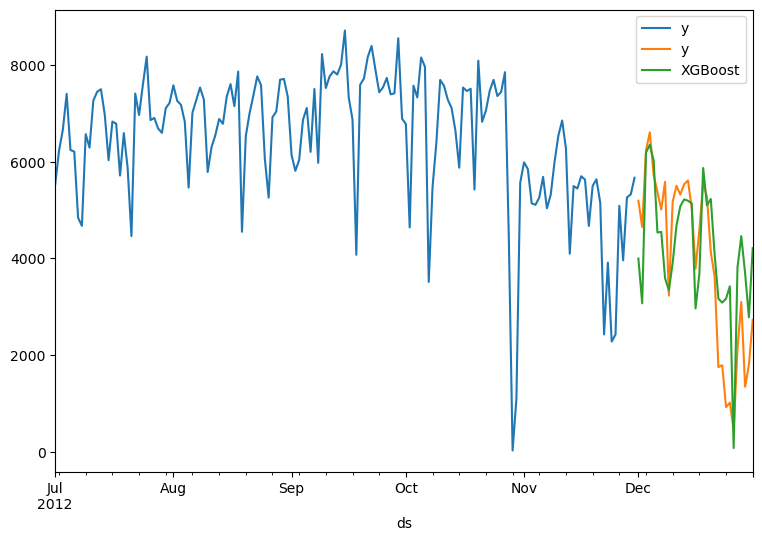

In [57]:
#Viz
training_set.y['2012-07-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions_xgb.plot(legend = True)

In [58]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_xgb),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_xgb)), 0))

946.0
1174.0


In [59]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_xgb)

45.377004733275925